## 박막-스플라인 TPS 모델
- 굴곡진(왜곡된) 메쉬그리드를 입력받아 평평한 메쉬 그리드로 바꿔주는 간단한 모델이다
- 이미지 => 3d mesh-grid로 만드는(예측, 복원) 모델 구조 + 예측된 3d 메쉬그리드를 3d 평면상에서 평활화(3d골곡보정 및 2d원근변환)하는 모델구조 (dewarp) => 수정필요(현재 코드와는 다른 개념인듯하다)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_data(grid_size=32, distortion_factor=0.1):
    x = np.linspace(-1, 1, grid_size)
    y = np.linspace(-1, 1, grid_size)
    x, y = np.meshgrid(x, y)
    z = np.zeros_like(x)

    # 왜곡 추가
    distortion = distortion_factor * np.random.randn(*z.shape)
    distorted_z = z + distortion 

    return torch.tensor(x, dtype=torch.float32), \
           torch.tensor(y, dtype=torch.float32), \
           torch.tensor(distorted_z, dtype=torch.float32)

In [2]:
class MeshRestorationModel(nn.Module):
    '''메쉬그리드 복원 모델 클래스 정의'''
    
    def __init__(self):
        super(MeshRestorationModel, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x, y):
        z = torch.cat([x.unsqueeze(-1), y.unsqueeze(-1)], dim=-1)
        z = z.view(-1, 2)  # Flatten the input
        z = self.relu(self.fc1(z))
        z = self.relu(self.fc2(z))
        z = self.relu(self.fc3(z))
        z = self.fc4(z)
        return z

In [3]:
# 데이터 생성
x, y, distorted_z = generate_data()
original_z = torch.zeros_like(distorted_z)

In [4]:
# 모델 생성 설정
model = MeshRestorationModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
# 모델 학습
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    predicted_z = model(x, y).view_as(distorted_z)
    loss = criterion(predicted_z, distorted_z)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [0/1000], Loss: 0.0173
Epoch [10/1000], Loss: 0.0107
Epoch [20/1000], Loss: 0.0099
Epoch [30/1000], Loss: 0.0098
Epoch [40/1000], Loss: 0.0098
Epoch [50/1000], Loss: 0.0097
Epoch [60/1000], Loss: 0.0097
Epoch [70/1000], Loss: 0.0097
Epoch [80/1000], Loss: 0.0096
Epoch [90/1000], Loss: 0.0096
Epoch [100/1000], Loss: 0.0095
Epoch [110/1000], Loss: 0.0095
Epoch [120/1000], Loss: 0.0095
Epoch [130/1000], Loss: 0.0094
Epoch [140/1000], Loss: 0.0094
Epoch [150/1000], Loss: 0.0093
Epoch [160/1000], Loss: 0.0093
Epoch [170/1000], Loss: 0.0093
Epoch [180/1000], Loss: 0.0092
Epoch [190/1000], Loss: 0.0092
Epoch [200/1000], Loss: 0.0091
Epoch [210/1000], Loss: 0.0091
Epoch [220/1000], Loss: 0.0090
Epoch [230/1000], Loss: 0.0090
Epoch [240/1000], Loss: 0.0089
Epoch [250/1000], Loss: 0.0089
Epoch [260/1000], Loss: 0.0089
Epoch [270/1000], Loss: 0.0088
Epoch [280/1000], Loss: 0.0088
Epoch [290/1000], Loss: 0.0087
Epoch [300/1000], Loss: 0.0087
Epoch [310/1000], Loss: 0.0087
Epoch [320/1000], L

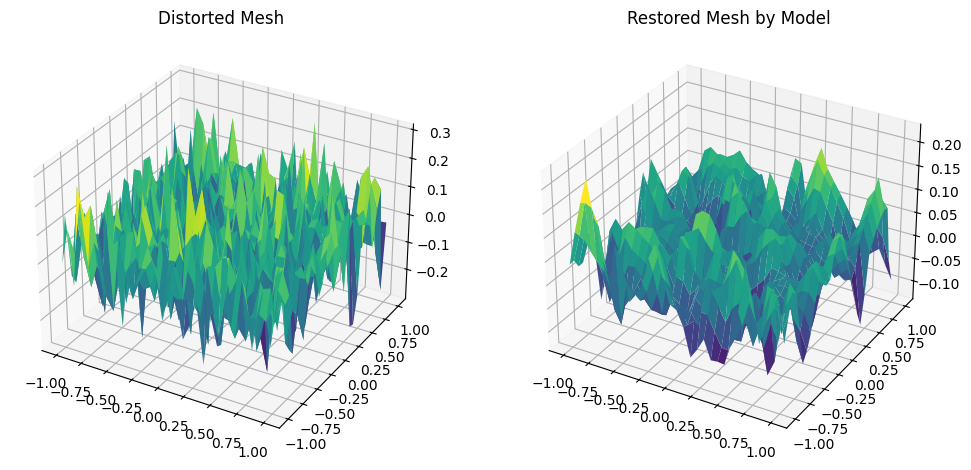

In [6]:
with torch.no_grad():
    predicted_z = model(x, y).view_as(distorted_z).numpy()

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x.numpy(), y.numpy(), distorted_z.numpy(), cmap='viridis')
ax1.set_title("Distorted Mesh")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x.numpy(), y.numpy(), predicted_z, cmap='viridis')
ax2.set_title("Restored Mesh by Model")

plt.show()